**Bitcoin Time Series Forecasting**

Bitcoin is the longest running and most well known cryptocurrency, first released as open source in 2009 by the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record keeping authority or central intermediary. Transaction blocks contain a SHA-256 cryptographic hash of previous transaction blocks, and are thus "chained" together, serving as an immutable record of all transactions that have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments soon followed public adoption of bitcoin and continue to grow.  If you don't know what Bitcoin is , then get some knowledge about Bitcoin [here](https://www.coindesk.com/information/what-is-bitcoin).

This Kernel is divided into two parts:-

* Data Exploration
* Time Series Analysis

And further for the **Time Series Forecasting:**-

*  Time Series forecasting with **LSTM**
* Time Series forecasting with **XGBoost**
* Time Series forecasting with Facebook **Prophet**
* Time Series forecasting with **ARIMA**

### **Importing Libraries**

In [2]:
pip install chart_studio

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc

import matplotlib.pyplot as plt
import seaborn as sns

### **Reading Data & Data Exploration**

In this section we just explore the Data i.e the Historic Bitcoin Prices and try to find some insights. We will be using the Coinbase dataset as it is one of the mostly used Bitcoin Exchange/Wallet in the world.

In [2]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

In [3]:
data = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv', parse_dates=[0], date_parser=dateparse)

C:\Users\hp\AppData\Local\Temp\ipykernel_11132\666071661.py:1: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016354 entries, 0 to 2016353
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   Timestamp          datetime64[ns, UTC]
 1   Open               float64            
 2   High               float64            
 3   Low                float64            
 4   Close              float64            
 5   Volume_(BTC)       float64            
 6   Volume_(Currency)  float64            
 7   Weighted_Price     float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 123.1 MB


In [5]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 11:03:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,2014-12-01 11:04:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-01 11:05:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-01 11:06:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-01 11:07:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Little preprocessing required, replacing the NaN values with zeroes and previous data.

In [6]:
# First thing is to fix the data for bars/candles where there are no trades.
# Volume/trades are a single event so fill na's with zeroes for relevant fields...
data['Volume_(BTC)'].fillna(value=0, inplace=True)
data['Volume_(Currency)'].fillna(value=0, inplace=True)
data['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 11:03:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,2014-12-01 11:04:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
2,2014-12-01 11:05:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
3,2014-12-01 11:06:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
4,2014-12-01 11:07:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0


Creating Weekly Rows for the Data Visualization

In [7]:
# create valid date range
start = datetime.datetime(2015, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2018, 11, 11, 0, 0, 0, 0, pytz.UTC)

# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = data[(data['Timestamp'] >= start) & (data['Timestamp'] <= end)].groupby([pd.Grouper(key='Timestamp', freq='W-MON')]).first().reset_index()
weekly_rows.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2015-01-12 00:00:00+00:00,360.00,360.00,360.00,360.00,0.010,3.600000,360.000000
1,2015-01-19 00:00:00+00:00,260.00,260.00,260.00,260.00,1.000,260.000000,260.000000
2,2015-01-26 00:00:00+00:00,225.51,225.51,225.51,225.51,0.000,0.000000,0.000000
3,2015-02-02 00:00:00+00:00,269.99,270.00,269.97,269.98,0.000,0.000000,0.000000
4,2015-02-09 00:00:00+00:00,225.74,227.55,225.01,227.55,34.403,7788.092574,226.378298


Lets visualize Historical Bitcoin prices (2015-2018)

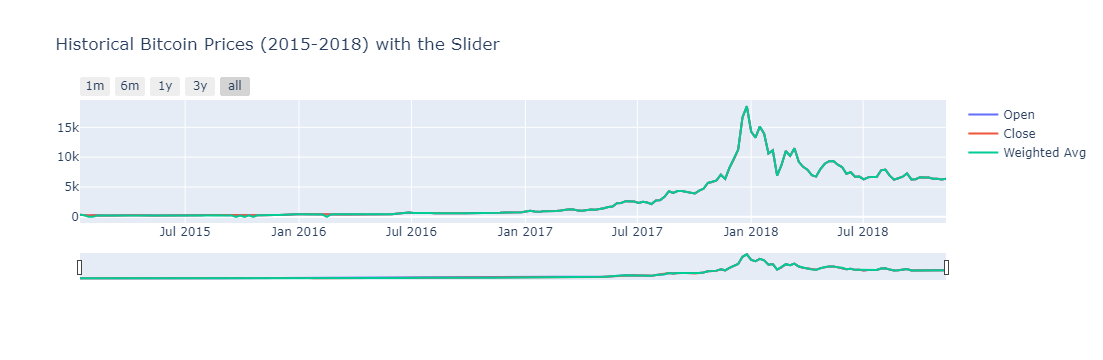

In [8]:
trace1 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Weighted_Price'].astype(float),
    mode = 'lines',
    name = 'Weighted Avg'
)

layout = go.Layout(
    title='Historical Bitcoin Prices (2015-2018) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

# fig = trace1
# fig.add_trace(trace2)
# fig.add_trace(trace3) go.Figure

fig_data = [trace1,trace2, trace3]
fig = go.Figure(data=fig_data, layout=layout)
# iplot(fig, filename = "Time Series with Rangeslider")
fig.show()

Lets visualize Historical Bitcoin Market Volume (2015-2018)

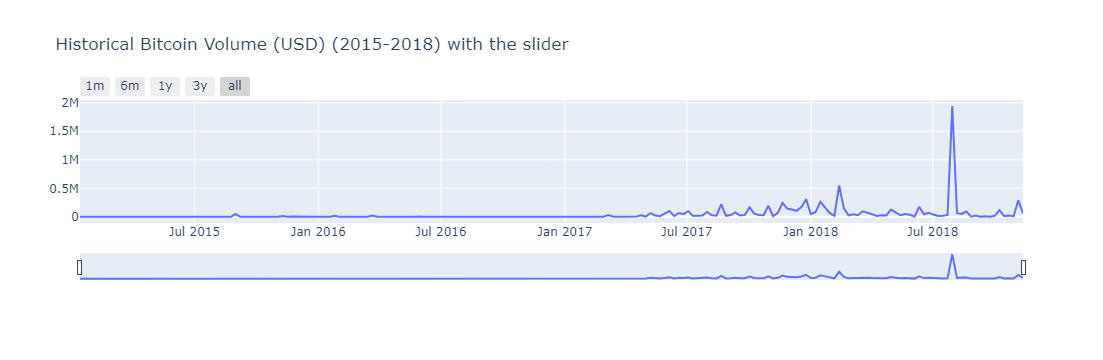

In [9]:
trace1 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Volume_(Currency)'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Bitcoin Volume (USD) (2015-2018) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig_data = [trace1]
fig = go.Figure(data=fig_data, layout=layout)
fig.show()

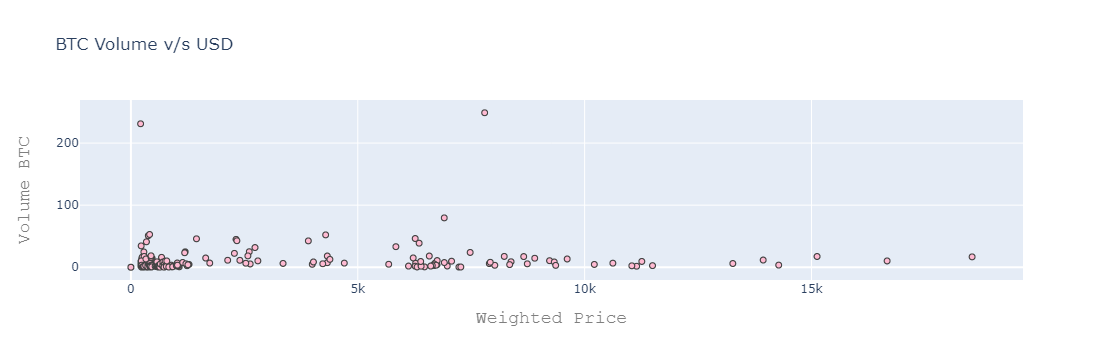

In [10]:
#BTC Volume vs USD visualization
trace = go.Scattergl(
    y = weekly_rows['Volume_(BTC)'].astype(float),
    x = weekly_rows['Weighted_Price'].astype(float),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
layout = go.Layout(
    title='BTC Volume v/s USD',
    xaxis=dict(
        title='Weighted Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Volume BTC',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )))
fig_data = [trace]
fig = go.Figure(data=fig_data, layout=layout)
fig.show()

**History of Bitcoin Prices**

*  18 August 2008, the domain name bitcoin.org was registered.
*  November 6th 2010, Bitcoin share capital reaches 1 million USD. Its exchange rate on MtGox reaches USD 0.50 per BTC.
*  June 2nd 2011, USD to BTC rate is 10 USD to the coin. For 6 days, the Bitcoin value is fixed at 31.91 USD on MtGox.
*  February 28th 2013, Bitcoin exchange rate surpasses 31.91 USD for the first time for the last 601 days.
*  April 1st,2013 Exchange rate of Bitcoin reaches 100 USD to 1 BTC.
*  January,2015 Coinbase raised 75 million USD as part of a Series C funding round, smashing the previous record for a bitcoin company.
*  February ,2015 Bitcoin price reached USD 262.
*  January 2017,After the rally for most of the second half of 2016, bitcoin broke the USD 1,000 mark for the first time in 3 years.
*  June 12th 2017, Bitcoin exchange rate exceeds USD 3000 to the BTC.
*  November 29th 2017, Bitcoin price exceeds USD 10,000.
*  December 18th 2017, Bitcoin reaches a record high, but does not reach USD 20,000.
*  December 28th 2017, The price of bitcoins fell after South Korea announced additional measures to regulate bitcoin trading, including the potential closure of exchanges, among the volatile movements in the world's third largest cryptocurrency market.
* October 31st 2018, USD 6,300, on the 10 year anniversary of Bitcoin, price holds steady above USD 6,000 during a period of historically low volatility.

**Time Series Forecasting**

Time Series data is an experimental data which has been observed at different points in time (usually evenly spaced, like once a day or once an hour or once a minute). For example, the data of airline ticket sales per day is a time series. However, just because a series of events has a time element does not automatically make it a time series, such as the dates of major airline disasters, which are randomly spaced and are not time series. These types of random processes are known as point process.

Time Series have several key features such as trend, seasonality, and noise.Forecasting is the process of making predictions of the future, based on past and present data.

Here in this kernel, we attempt to perform Time Series Analysis on the Historic Bitcoin Price data. We can easily see from the **Data Exploration** section, that the Bitcoin prices were quite volatile and inconsistent over the years.  Its very hard to perform Time series analysis on such volatile data. But here we try to explore the different Time series forecasting models. All the models used in this Kernel are very basic, there is scope of more complex and better performing models.  

*  Time Series forecasting with LSTM
* Time Series forecasting with XGBoost
* Time Series forecasting with Facebook Prophet
* Time Series forecasting with ARIMA

**Predicting using LSTM**

In the first section, we use LSTM  (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. Read more about LSTMs [here.](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

In [9]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bitcoin Price - Time Series Forecasting/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv', parse_dates=[0], date_parser=dateparse)

In [10]:
# Let's remove the time zone information while keeping the local time (not converted to UTC)
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)

# Then let's grouoby the data on Timestamp with hourly frequency
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()

# After setting Timestamp as the index let's just keep the Weighted Price
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]

# Finally, fill the NA values using ffile, i.e.,  propagate the last valid observation forward
data['Weighted_Price'].fillna(method='ffill', inplace=True)

For the train and test, we take '25-Jun-2018' as the split date.  There was a considerable dip in Bitcoin prices between the June-July period 2018.  If we check the historical prices the seasonal market started going up from this date after reaching the lowest, though the price reached much lower $5972 on June 29th 2018. After reaching the historic 20K mark on December 18th, there were several dips and market price was recorrected every time. Read more about [Bitcoin dips.](http://https://news.bitcoin.com/data-reveals-reasons-behind-bitcoins-big-dip/)

In [11]:
# split data
split_date = '25-Jun-2018'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [12]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

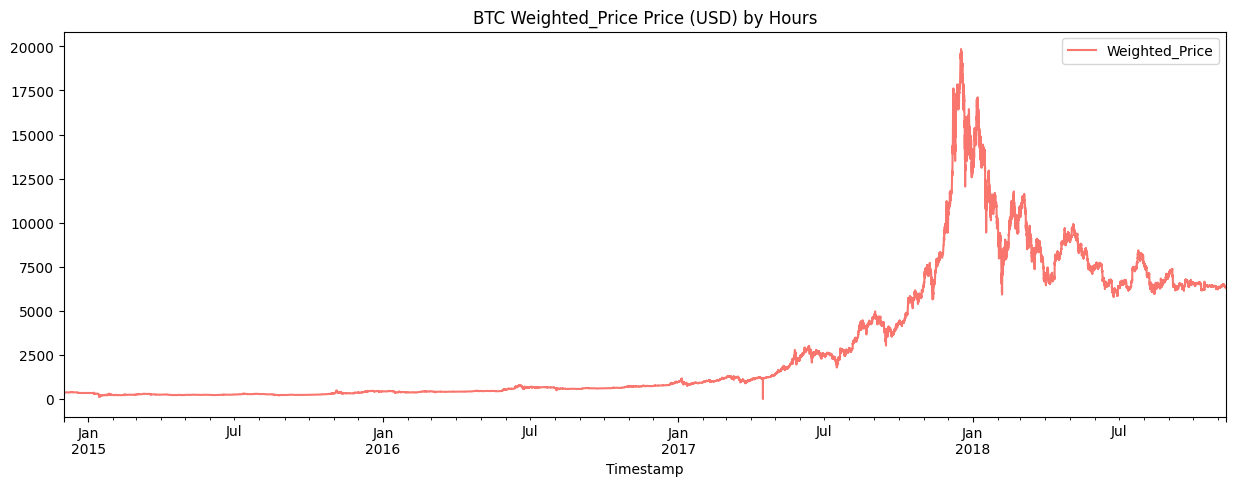

In [34]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

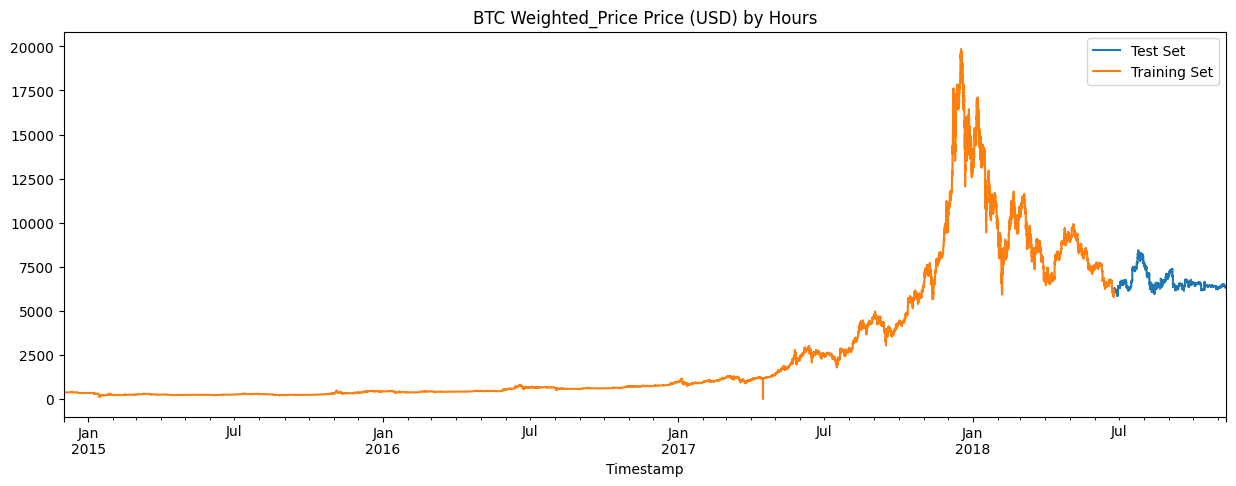

In [35]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

We will use a Vanilla LSTM here for forecasting. The model is trained on pre 25-Jun-2018 data.

In [13]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

In [14]:
model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
625/625 - 5s - loss: 0.0356 - 5s/epoch - 8ms/step
Epoch 2/100
625/625 - 3s - loss: 0.0118 - 3s/epoch - 4ms/step
Epoch 3/100
625/625 - 3s - loss: 0.0064 - 3s/epoch - 4ms/step
Epoch 4/100
625/625 - 4s - loss: 0.0044 - 4s/epoch - 6ms/step
Epoch 5/100
625/625 - 3s - loss: 0.0034 - 3s/epoch - 5ms/step
Epoch 6/100
625/625 - 3s - loss: 0.0028 - 3s/epoch - 5ms/step
Epoch 7/100
625/625 - 3s - loss: 0.0023 - 3s/epoch - 5ms/step
Epoch 8/100
625/625 - 2s - loss: 0.0019 - 2s/epoch - 3ms/step
Epoch 9/100
625/625 - 2s - loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 10/100
625/625 - 2s - loss: 0.0014 - 2s/epoch - 4ms/step
Epoch 11/100
625/625 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 12/100
625/625 - 2s - loss: 0.0011 - 2s/epoch - 4ms/step
Epoch 13/100
625/625 - 3s - loss: 0.0010 - 3s/epoch - 5ms/step
Epoch 14/100
625/625 - 3s - loss: 9.1385e-04 - 3s/epoch - 4ms/step
Epoch 15/100
625/625 - 2s - loss: 8.3988e-04 - 2s/epoch - 3ms/step
Epoch 16/100
625/625 - 2s - loss: 7.5482e-04 - 2s/epoch 

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

105/105 [==============================] - 1s 4ms/step


In [17]:
data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

In [18]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})
final_data = final_data[['Timestamp','Weighted_Price','lstm']]

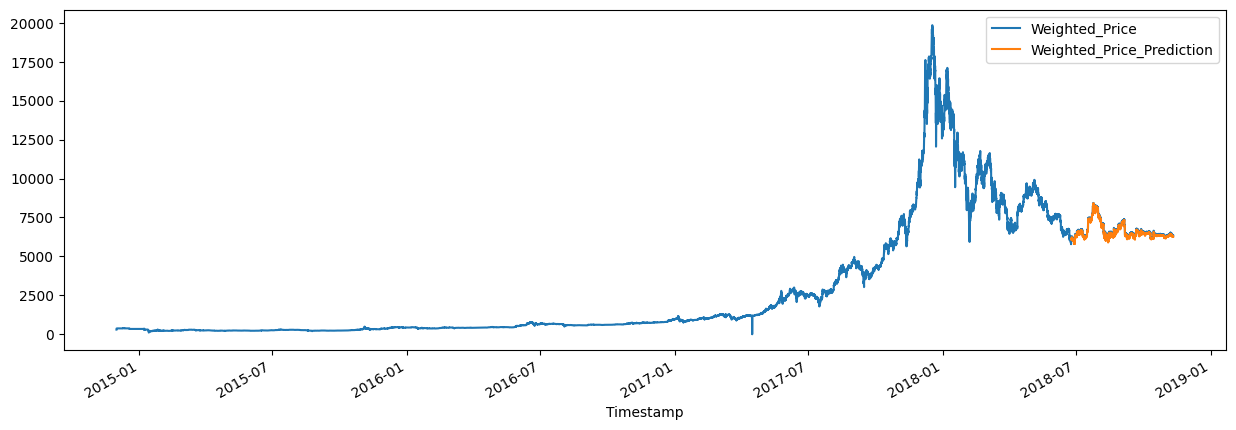

In [40]:
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

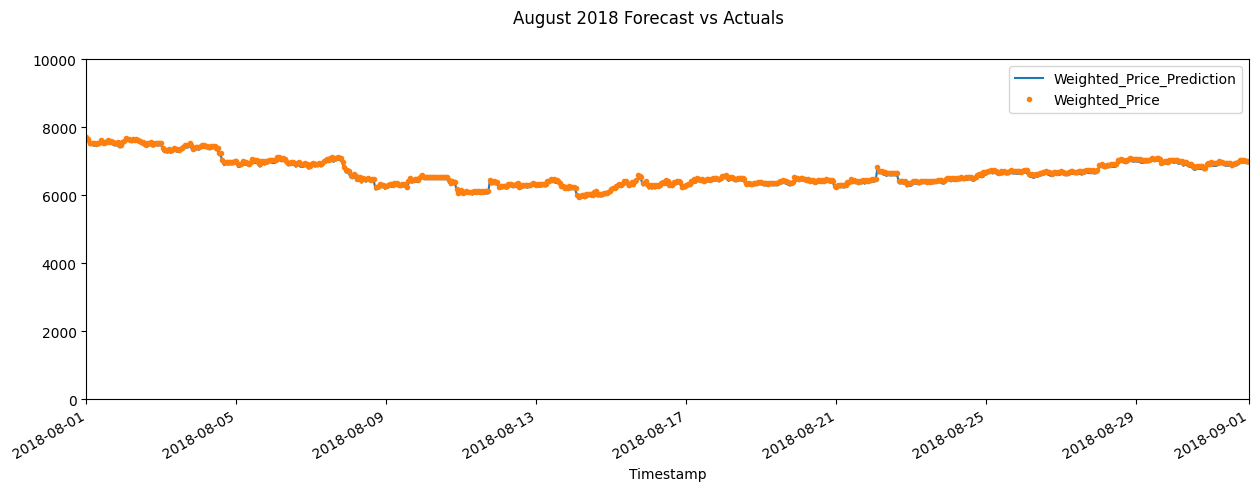

In [41]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2018', upper='09-01-2018')
ax.set_ylim(0, 10000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

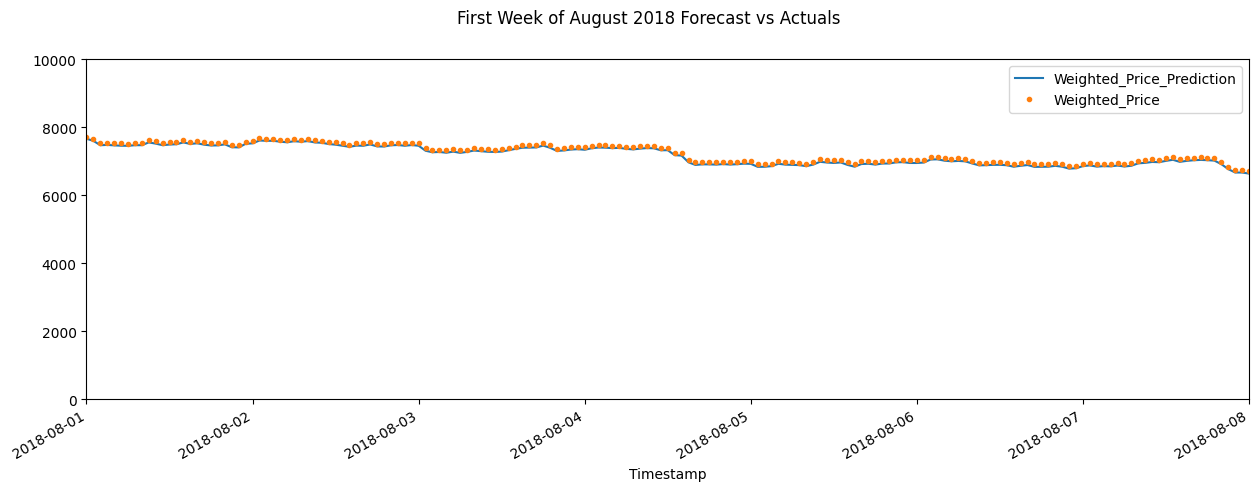

In [42]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2018', upper='08-08-2018')
ax.set_ylim(0, 10000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

The MSE is 993.80 and MAE is 30.85

In [19]:
# Calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

993.8011927566027

In [20]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

30.850259967309274

We can clearly see the entire model is over-fitted.

**Time Series forecasting with XGBoost**

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. XGBoost is a powerful and versatile tool. Lets see, How well does XGBoost perform when used to predict future values of a time-series like Bitcoin prices ?

Read more about [XGBoost here.](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [22]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bitcoin Price - Time Series Forecasting/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv', parse_dates=[0], date_parser=dateparse)
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

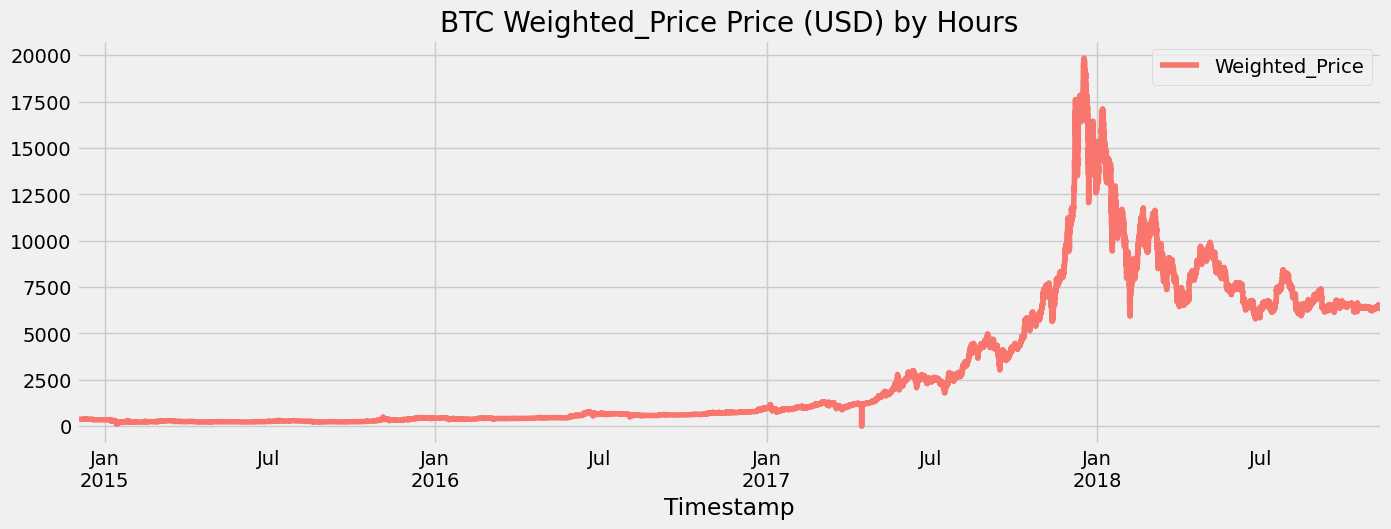

In [23]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

In [24]:
split_date = '25-Jun-2018'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

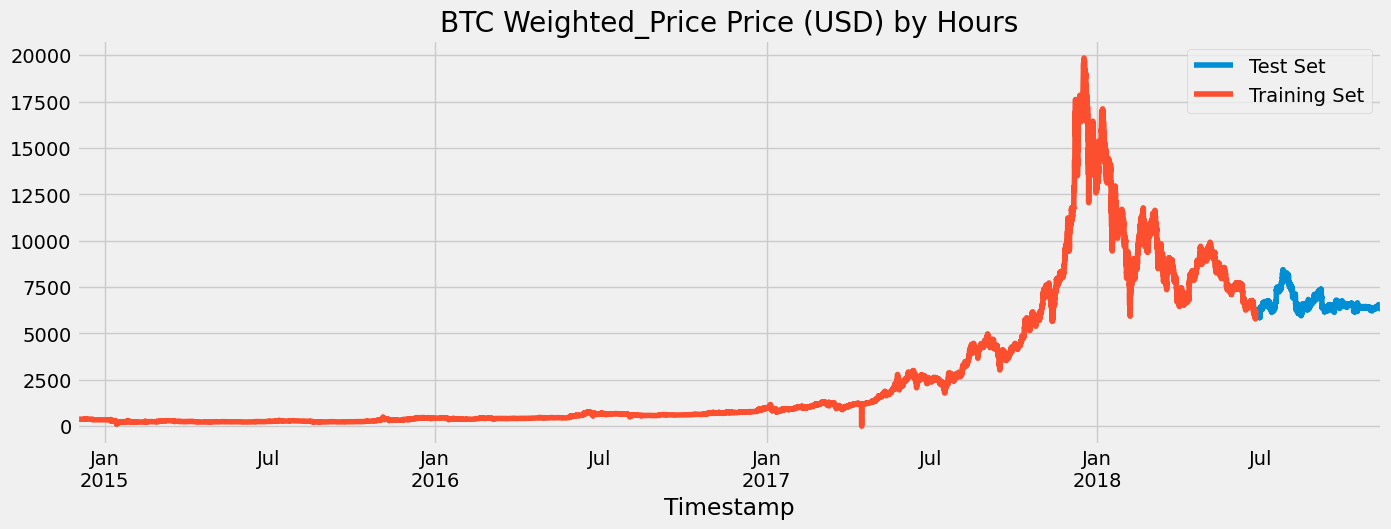

In [11]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [25]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [26]:
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

<ipython-input-25-ef221b55ea67>:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.

<ipython-input-25-ef221b55ea67>:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



Here we use a basic XGBRegressor model,

In [27]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[13:08:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



XGBRegressor(alpha=10, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [28]:
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

In [29]:
#adding to final data for comparision
final_data = pd.merge(final_data, data_all, sort=False)
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'xgboost'})
final_data = final_data[['Timestamp','Weighted_Price','lstm','xgboost']]

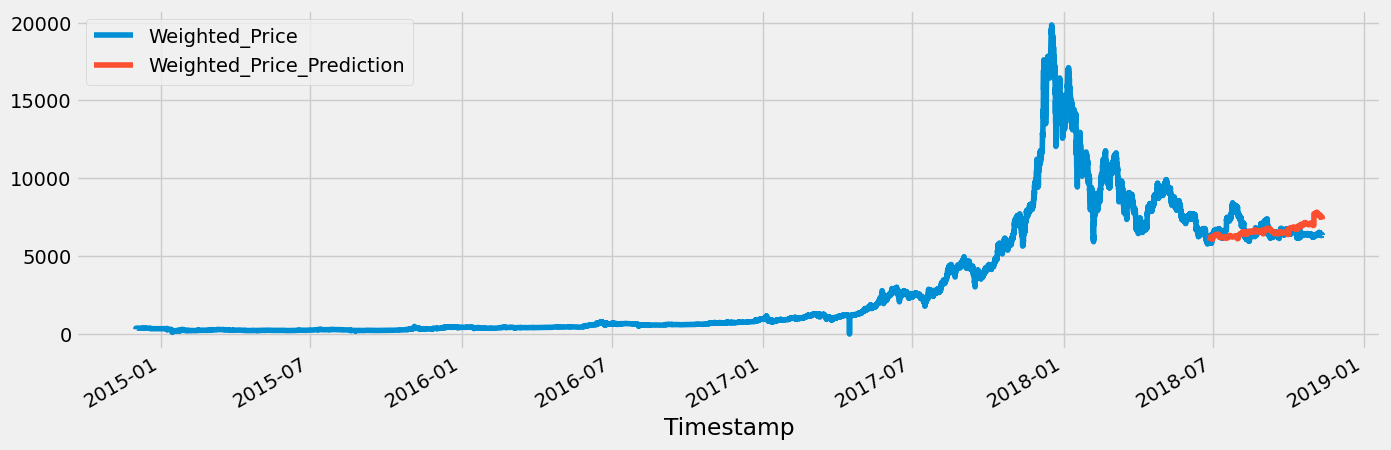

In [54]:
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

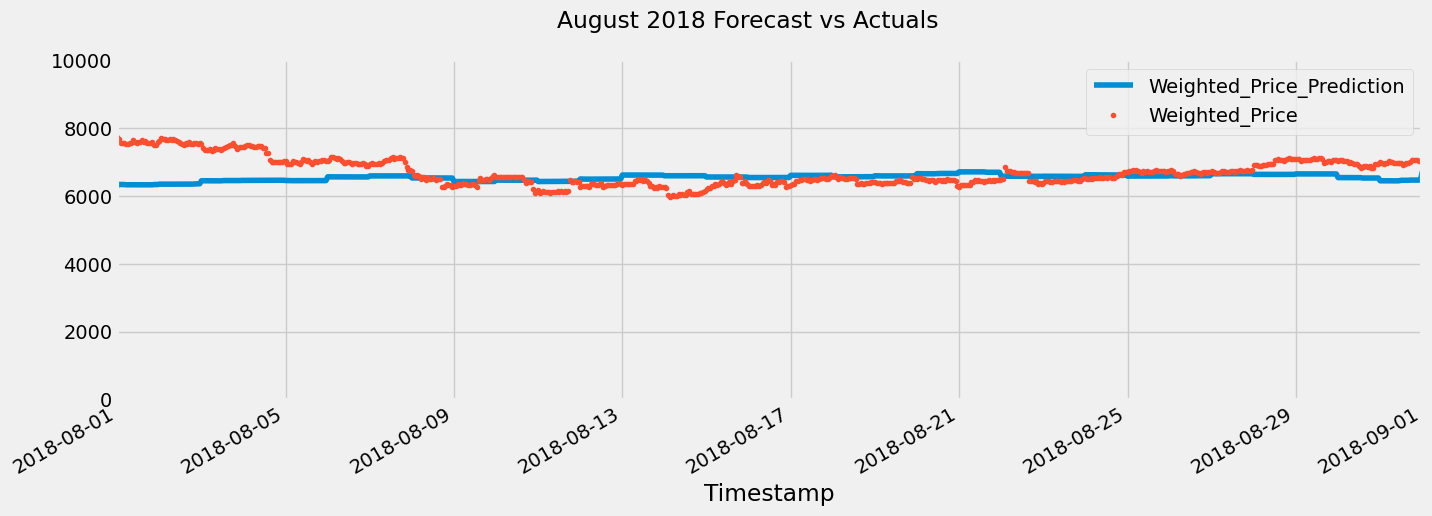

In [55]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2018', upper='09-01-2018')
ax.set_ylim(0, 10000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

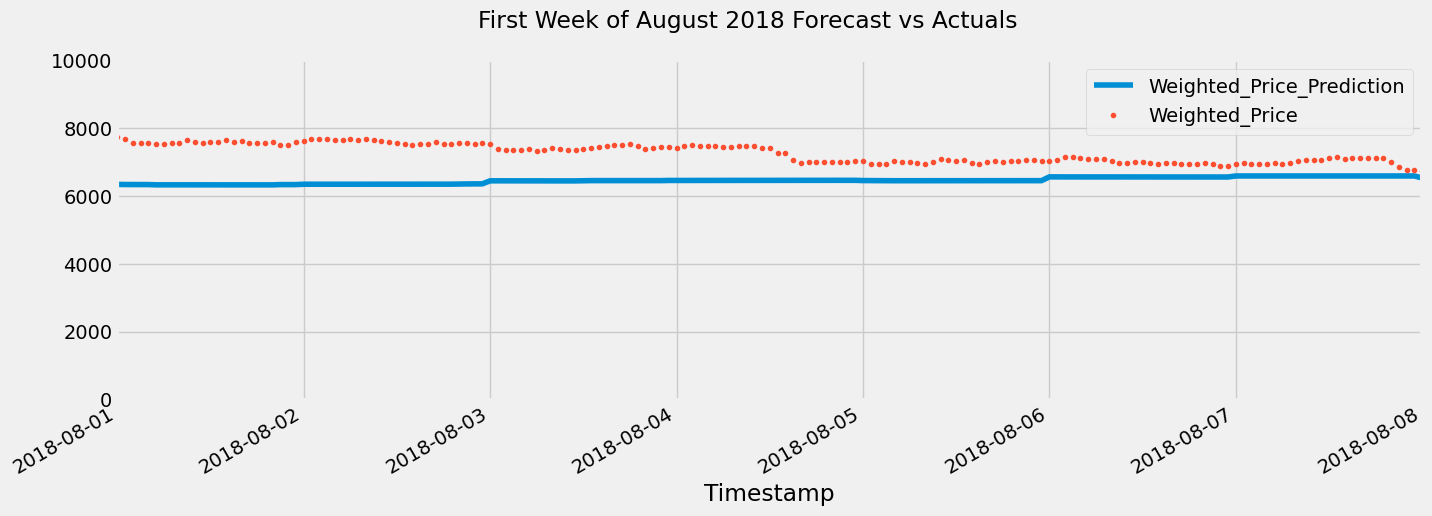

In [56]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2018', upper='08-08-2018')
ax.set_ylim(0, 10000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

The MSE is 537169.08 and MAE is 530.39

In [30]:
# Calculate MSE and MAE
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

537169.0753148857

In [31]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

530.3923898824415

**Time Series forecasting with Prophet**

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. Refer [Prophet here.](https://facebook.github.io/prophet/)

The Prophet package provides intuitive parameters which are easy to tune. Even someone with minimum expertise in forecasting models can use this to make meaningful predictions for a variety of problems in a business scenario.





In [32]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bitcoin Price - Time Series Forecasting/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv', parse_dates=[0], date_parser=dateparse)
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

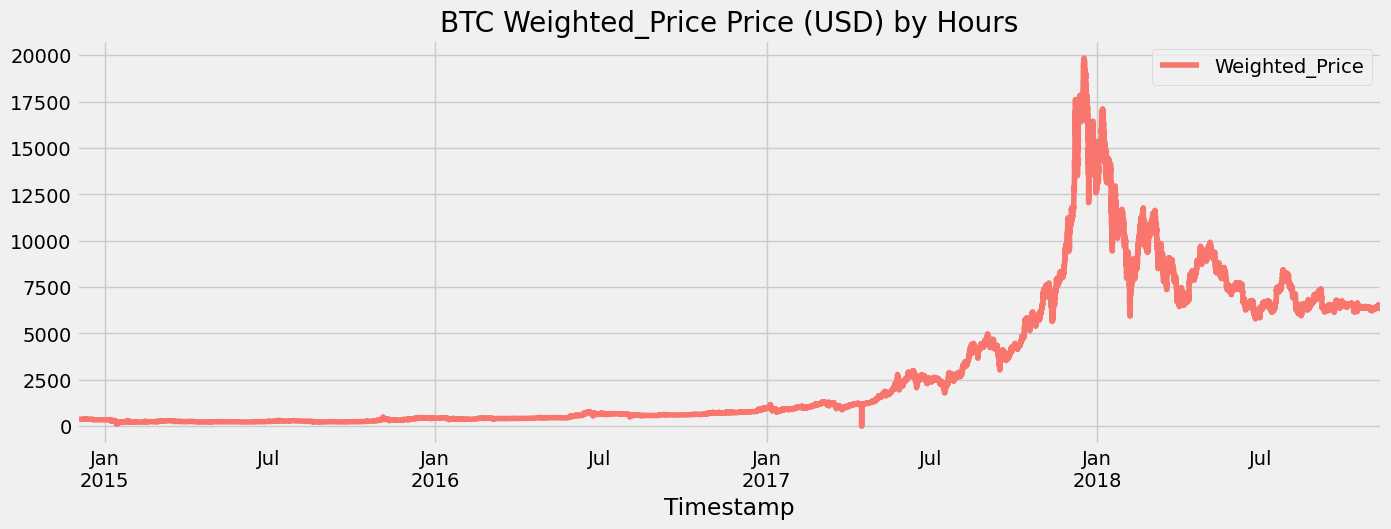

In [23]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

In [33]:
split_date = '25-Jun-2018'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

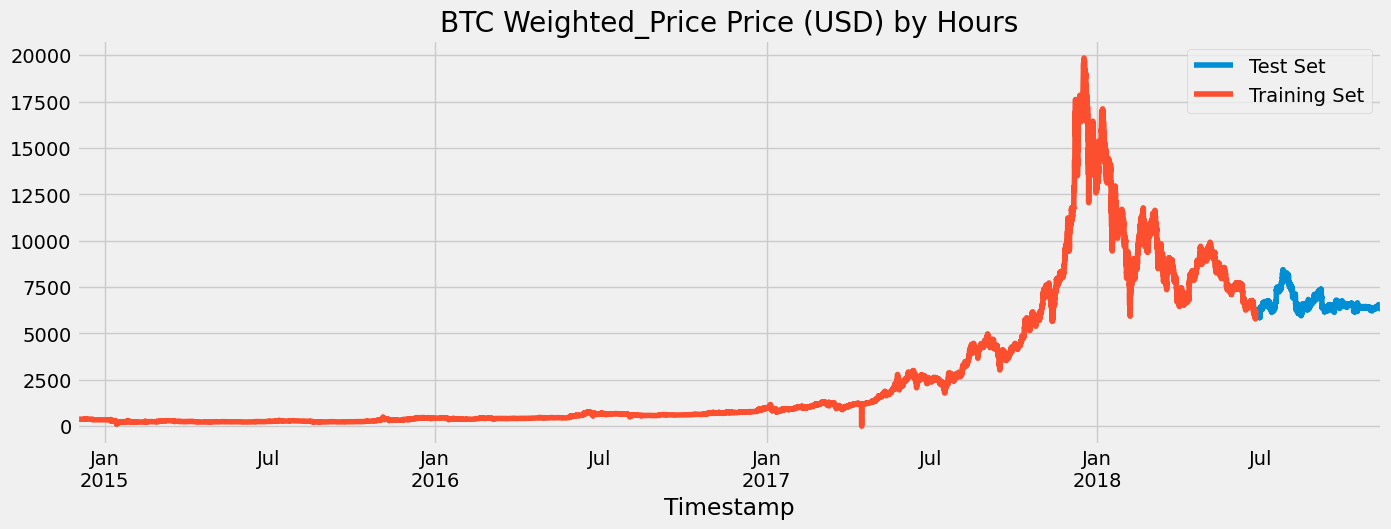

In [25]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [34]:
data_train = data_train.reset_index().rename(columns={'Timestamp':'ds', 'Weighted_Price':'y'})

In [35]:
# Setup and train model
model = Prophet()
model.fit(data_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzteqe7xt/pdlu0xua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzteqe7xt/z63jjd2d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18613', 'data', 'file=/tmp/tmpzteqe7xt/pdlu0xua.json', 'init=/tmp/tmpzteqe7xt/z63jjd2d.json', 'output', 'file=/tmp/tmpzteqe7xt/prophet_model3eifbcd9/prophet_model-20231212130939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:09:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:11:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [36]:
# Predict on training set with model
data_test_fcst = model.predict(df=data_test.reset_index().rename(columns={'Timestamp':'ds'}))

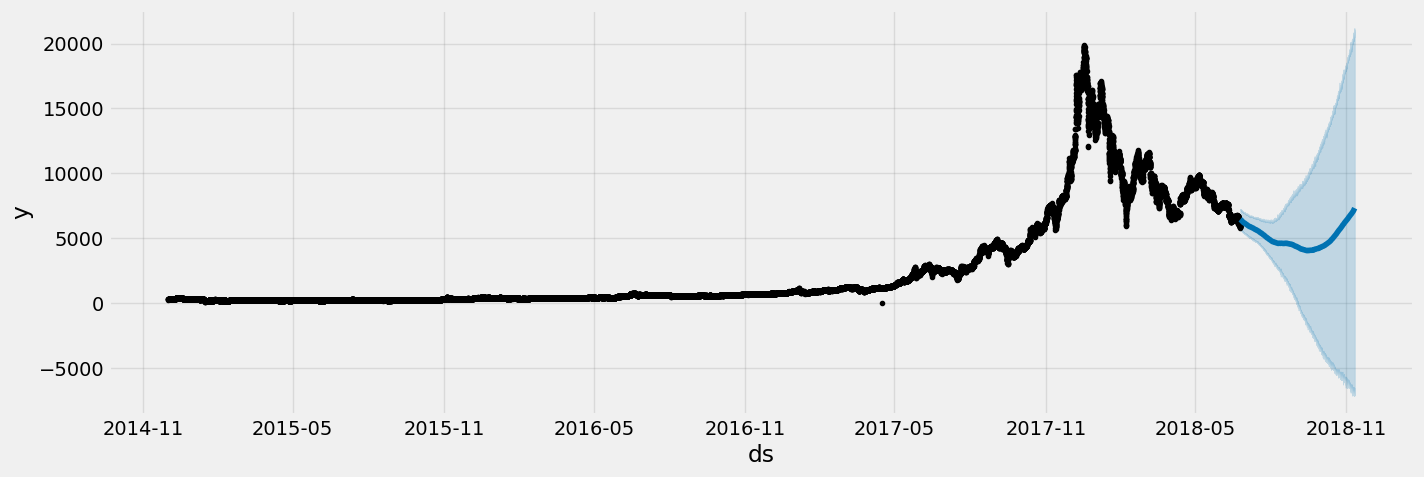

In [29]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(data_test_fcst, ax=ax)

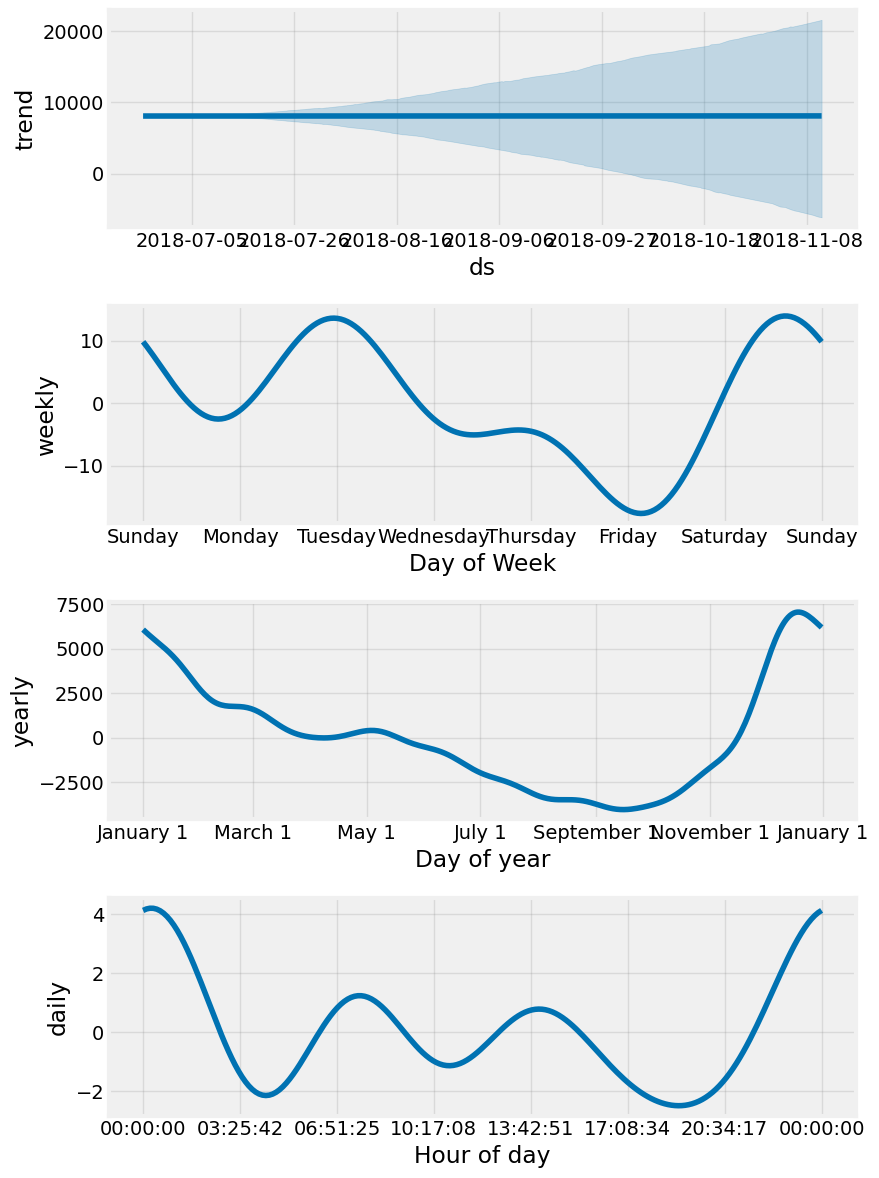

In [30]:
# Plot the components
fig = model.plot_components(data_test_fcst)

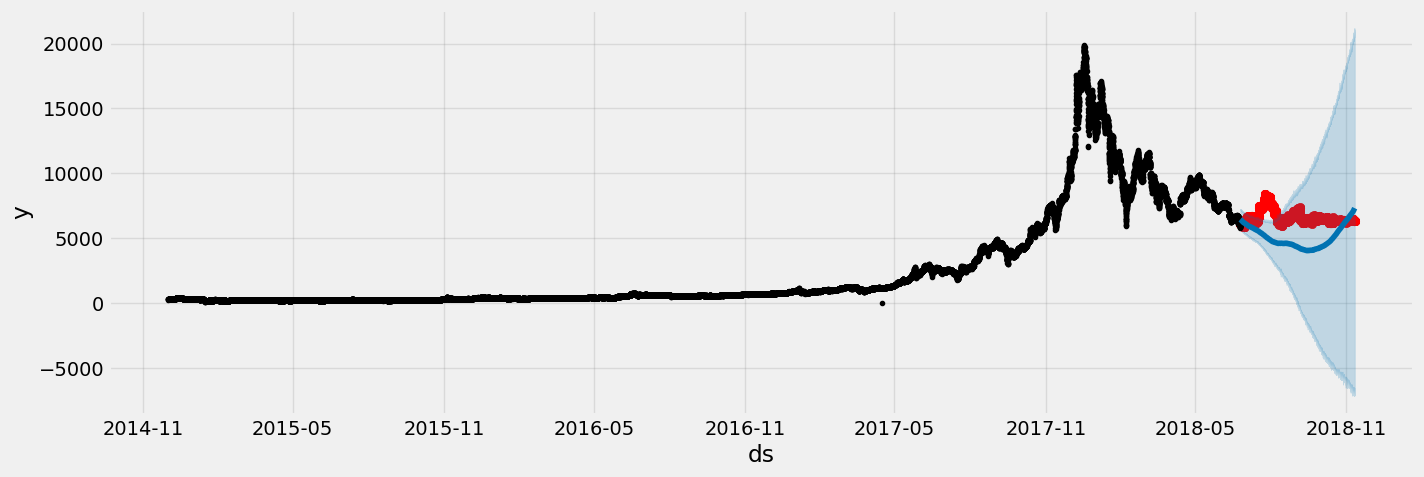

In [31]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['Weighted_Price'], color='r')
fig = model.plot(data_test_fcst, ax=ax)

In [37]:
#for comparision of predictions
data_fcst = data_test_fcst
data_fcst = data_fcst.rename(columns={'ds': 'Timestamp'})
data_all = pd.concat([data_fcst, data_train], sort=False)
final_data = pd.merge(final_data, data_all, sort=False)
final_data = final_data.rename(columns={'yhat': 'prophet'})
final_data = final_data[['Timestamp','Weighted_Price','lstm','xgboost','prophet']]

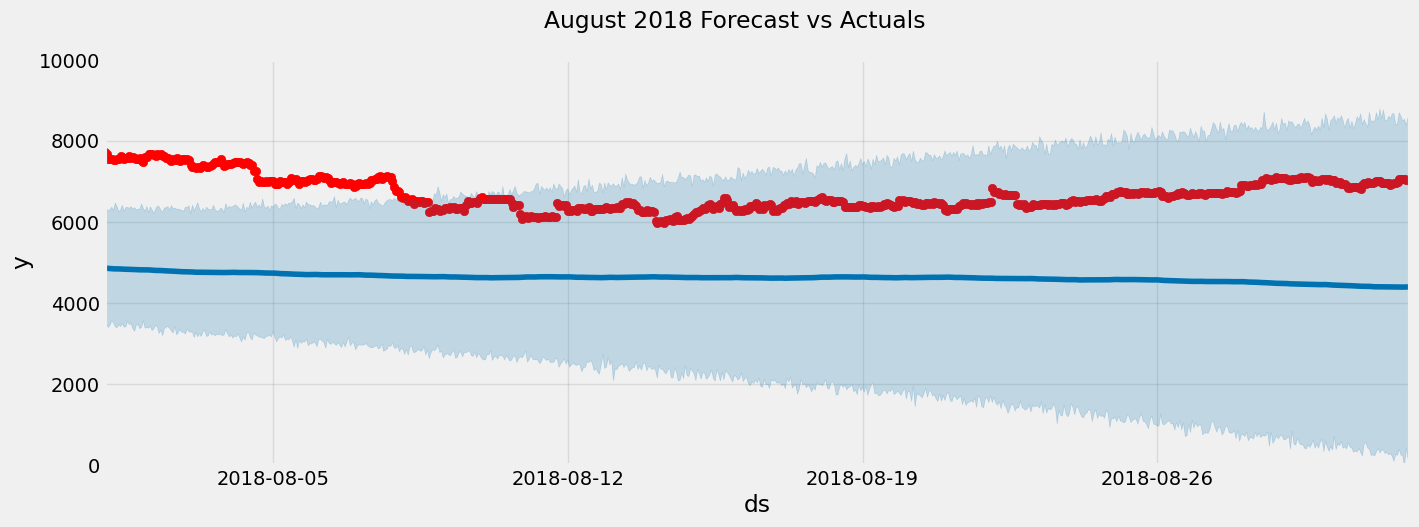

In [52]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['Weighted_Price'], color='r')
fig = model.plot(data_test_fcst, ax=ax)
lower_xbound = datetime.datetime.strptime('2018-08-01', '%Y-%m-%d').date()
upper_xbound = datetime.datetime.strptime('2018-09-01', '%Y-%m-%d').date()
ax.set_xbound(lower=lower_xbound, upper=upper_xbound)
ax.set_ylim(0, 10000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

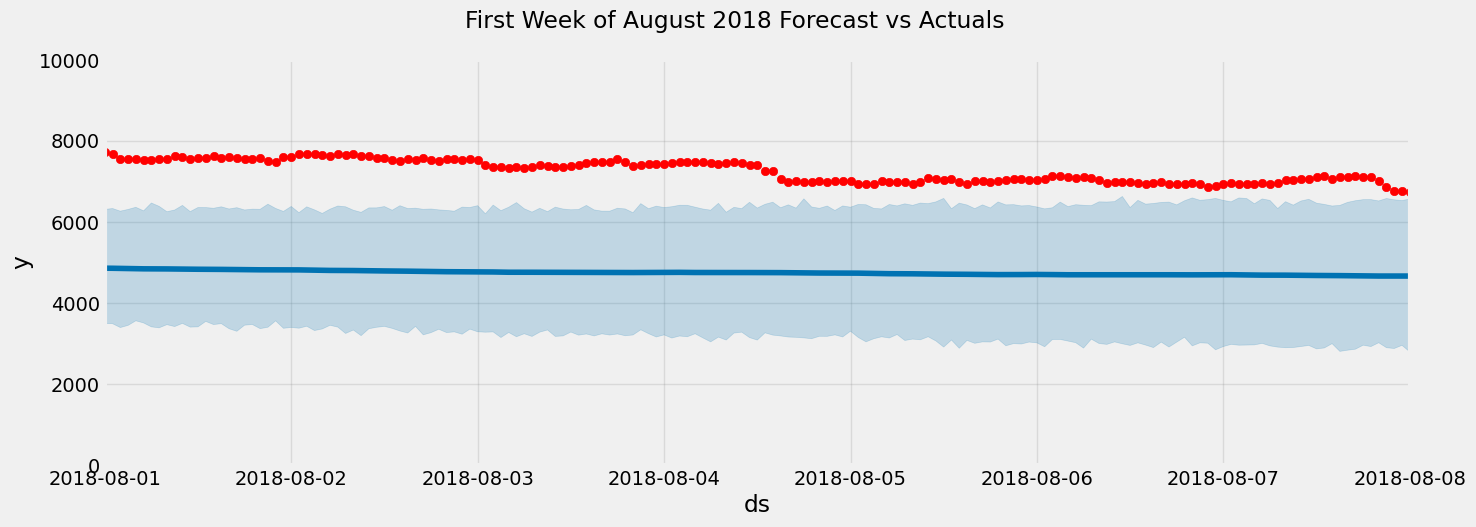

In [53]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['Weighted_Price'], color='r')
fig = model.plot(data_test_fcst, ax=ax)
lower_xbound = datetime.datetime.strptime('2018-08-01', '%Y-%m-%d').date()
upper_xbound = datetime.datetime.strptime('2018-08-08', '%Y-%m-%d').date()
ax.set_xbound(lower=lower_xbound, upper=upper_xbound)
ax.set_ylim(0, 10000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

The MSE is 3530475.76 and MAE is 1648.69

In [38]:
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test_fcst['yhat'])

3530475.763426189

In [55]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test_fcst['yhat'])

1648.6934889008282

**LSTM , XGBoost and Prophet - How good are they ?**

Here lets visualize and compare the predictive results of LSTM, XGBoost and Prophet in a single plot,

In [41]:
# Create traces
trace0 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['Weighted_Price'],
    mode = 'lines+markers',
    name = 'Real Price'
)
trace1 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['lstm'],
    mode = 'lines+markers',
    name = 'LSTM Prediction'
)
trace2 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['xgboost'],
    mode = 'lines+markers',
    name = 'XGBoost Prediction'
)
trace3 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['prophet'],
    mode = 'lines+markers',
    name = 'Prophet Prediction'
)

# Edit the layout
layout = dict(title = 'Comparision of LSTM,XGBoost and Prophet',
              xaxis = dict(title = 'Month'),
              yaxis = dict(title = 'Prices (USD)'),
              )

fig_data = [trace0, trace1, trace2, trace3]
fig = go.Figure(data=fig_data, layout=layout)
fig.show()

**Time Series forecasting using ARIMA**

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.
This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:
* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA is one of the mostly used techniques for Time Series analysis. In Python,  ARIMA based forecasting models can be created either using AutoARIMA[(Pyramid ARIMA)](https://pypi.org/project/pyramid-arima/) or [StatsModel ](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html). Here we will be using StatsModel as Kaggle do not support Pyramid ARIMA till now.

In [56]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

In [57]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bitcoin Price - Time Series Forecasting/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv', parse_dates=[0], date_parser=dateparse)

In [58]:
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)
data['Weighted_Price'].fillna(method='ffill', inplace=True)
data['Volume_(BTC)'].fillna(method='ffill', inplace=True)
data['Volume_(Currency)'].fillna(method='ffill', inplace=True)

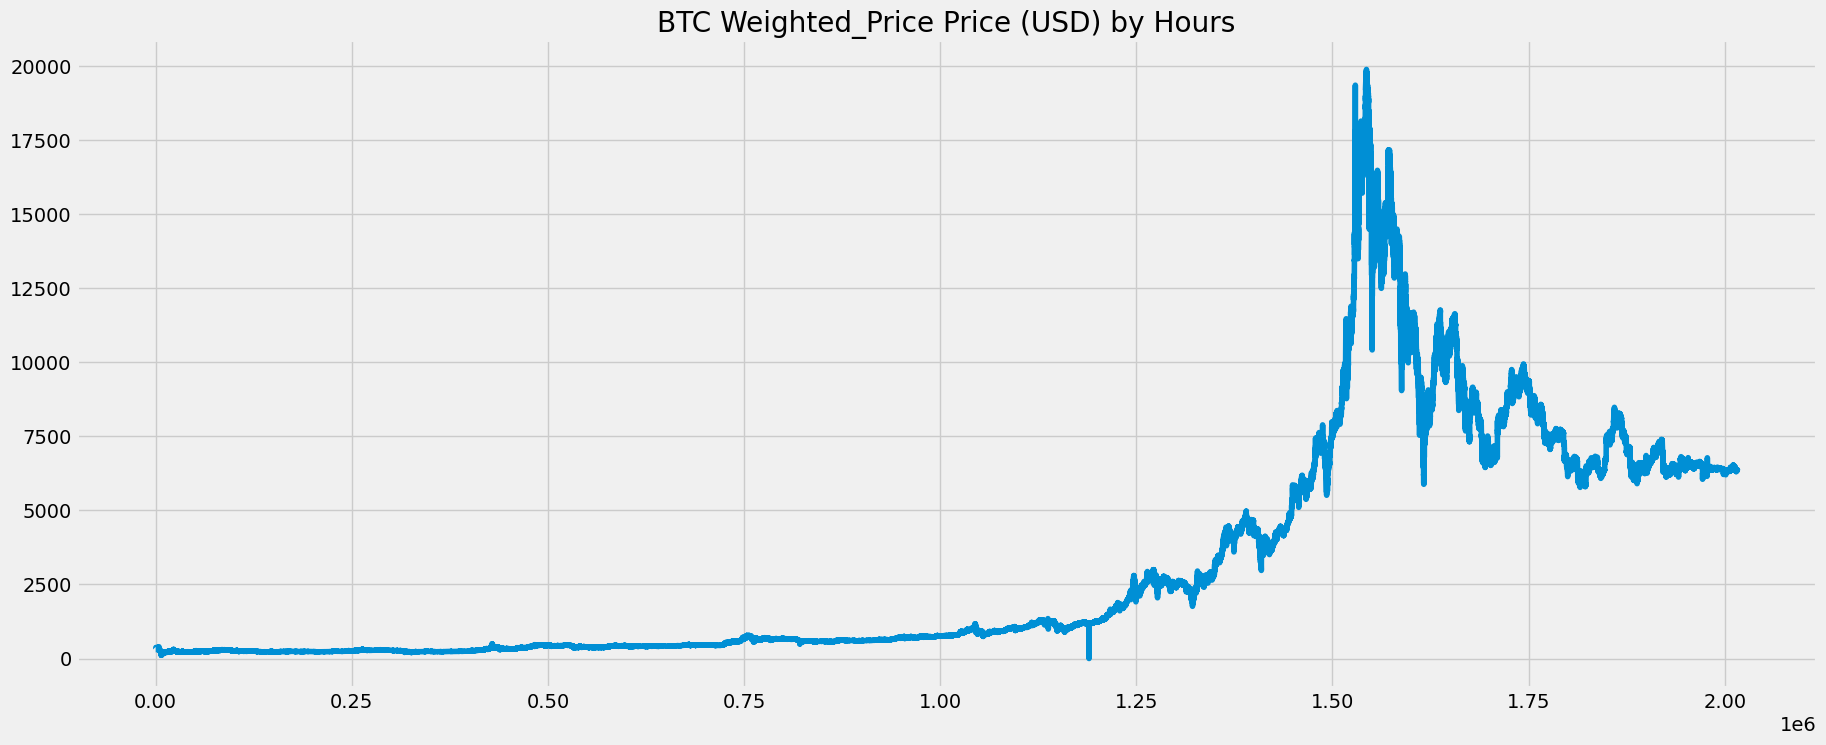

In [59]:
plt.figure(figsize=[20,8])
plt.title('BTC Weighted_Price Price (USD) by Hours')
plt.plot(data.Weighted_Price, '-', label='By Hours')

In previous sections of LSTM,XGBoost and Prophet, we used hourly data to train the model. But here we will use the monthly data (for Seasonality).

In [60]:
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='M')]).first().reset_index()
data = data.set_index('Timestamp')
data['Weighted_Price'].fillna(method='ffill', inplace=True)

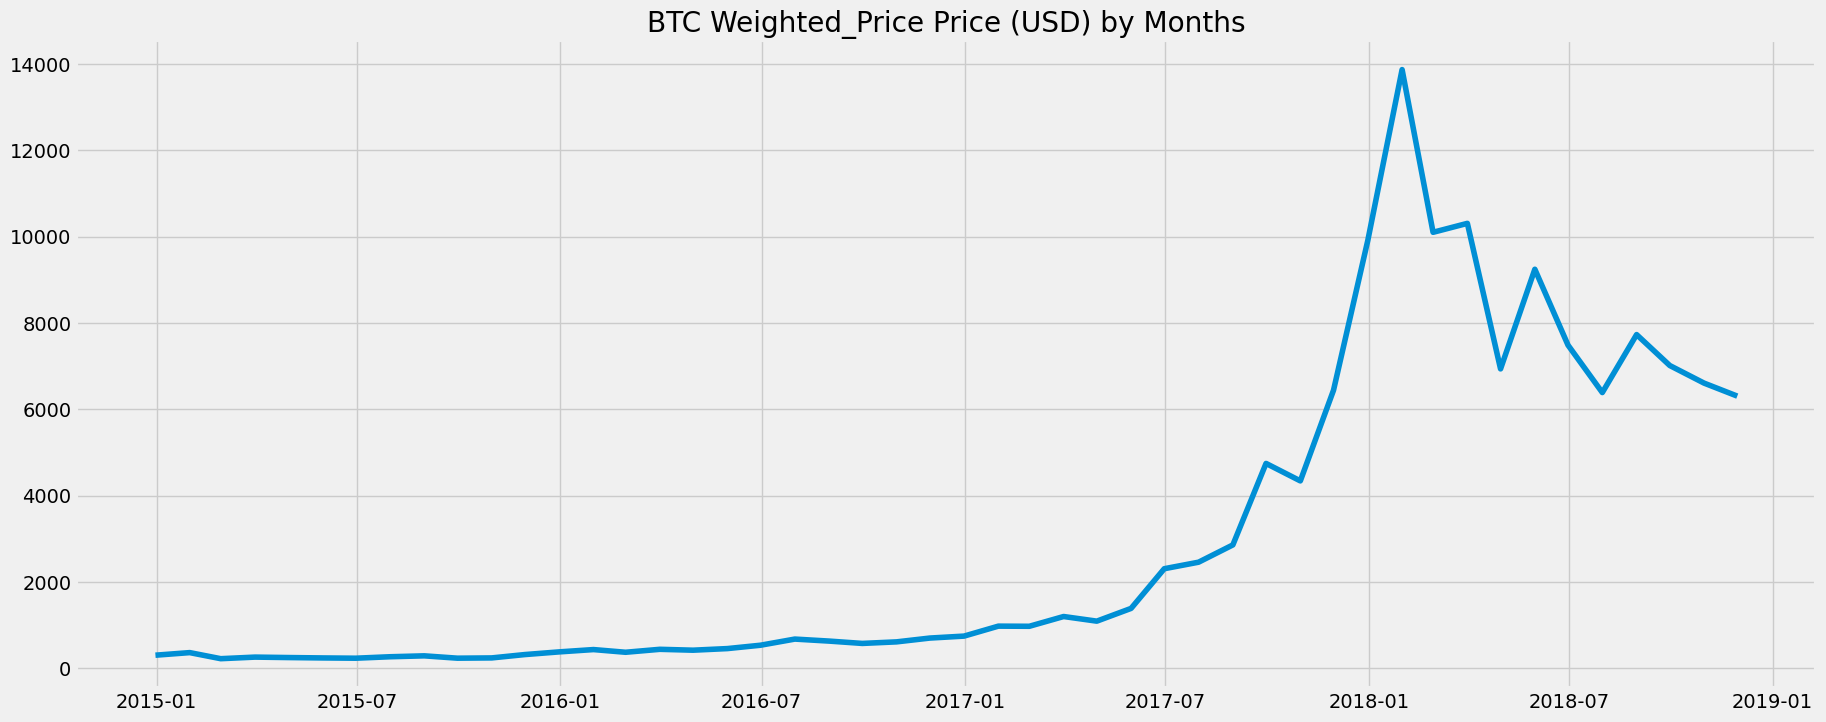

In [61]:
plt.figure(figsize=[20,8])
plt.title('BTC Weighted_Price Price (USD) by Months')
plt.plot(data.Weighted_Price, '-', label='By Months')

Decomposition

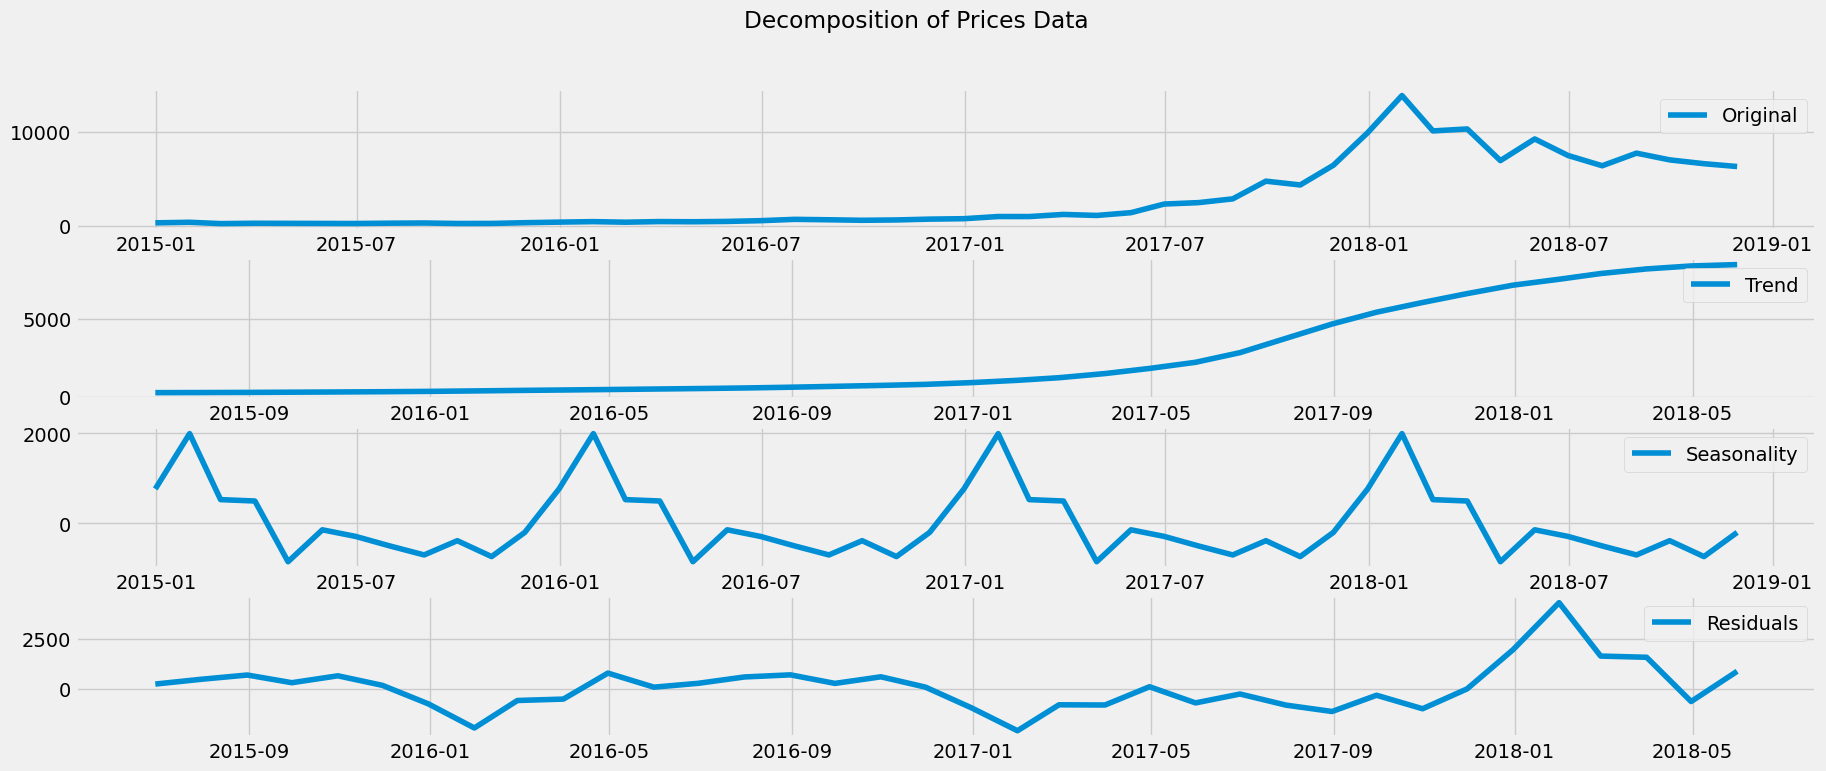

In [62]:
decomposition = sm.tsa.seasonal_decompose(data.Weighted_Price)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data.Weighted_Price, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

In [63]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.Weighted_Price)[1])

Dickey–Fuller test: p=1.000000


In [65]:
len(data.Weighted_Price)

48

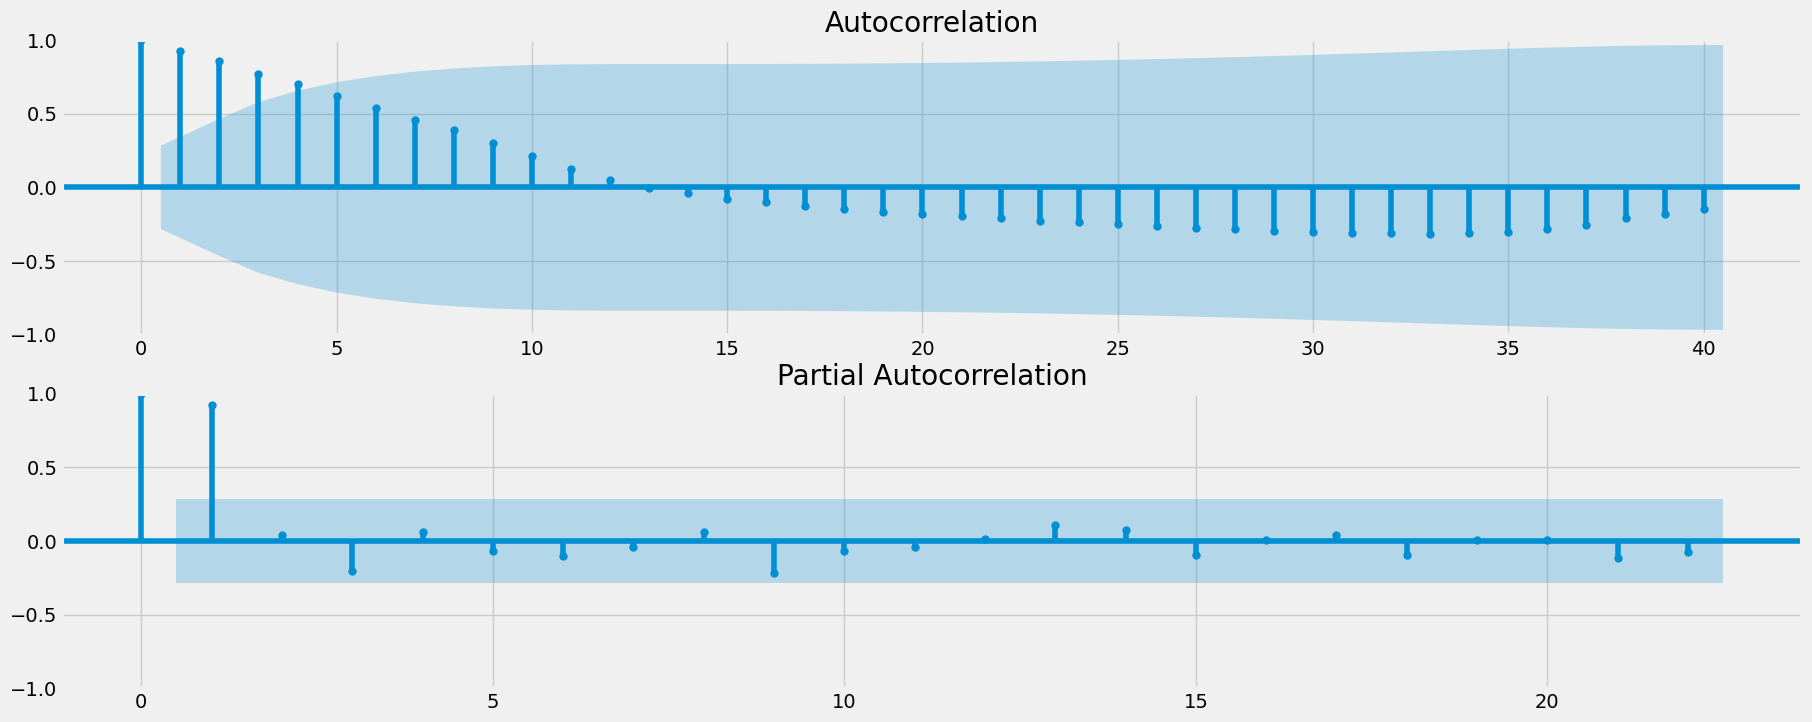

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(data.Weighted_Price, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(data.Weighted_Price, ax=pyplot.gca(), lags=22)
pyplot.show()

Here's the Statespace ARIMA Model, the best model is selected using different parameters.

In [68]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.Weighted_Price, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [69]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
53  (2, 2, 2, 1)  157.359317
40  (2, 0, 2, 0)  163.367109
46  (2, 1, 2, 0)  164.893641
41  (2, 0, 2, 1)  165.340388
47  (2, 1, 2, 1)  165.762233
                                      SARIMAX Results                                       
Dep. Variable:                       Weighted_Price   No. Observations:                   48
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 12)   Log Likelihood                 -70.680
Date:                              Tue, 12 Dec 2023   AIC                            157.359
Time:                                      12:58:08   BIC                            158.937
Sample:                                  12-31-2014   HQIC                           153.954
                                       - 11-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Dickey–Fuller test:: p=0.000000


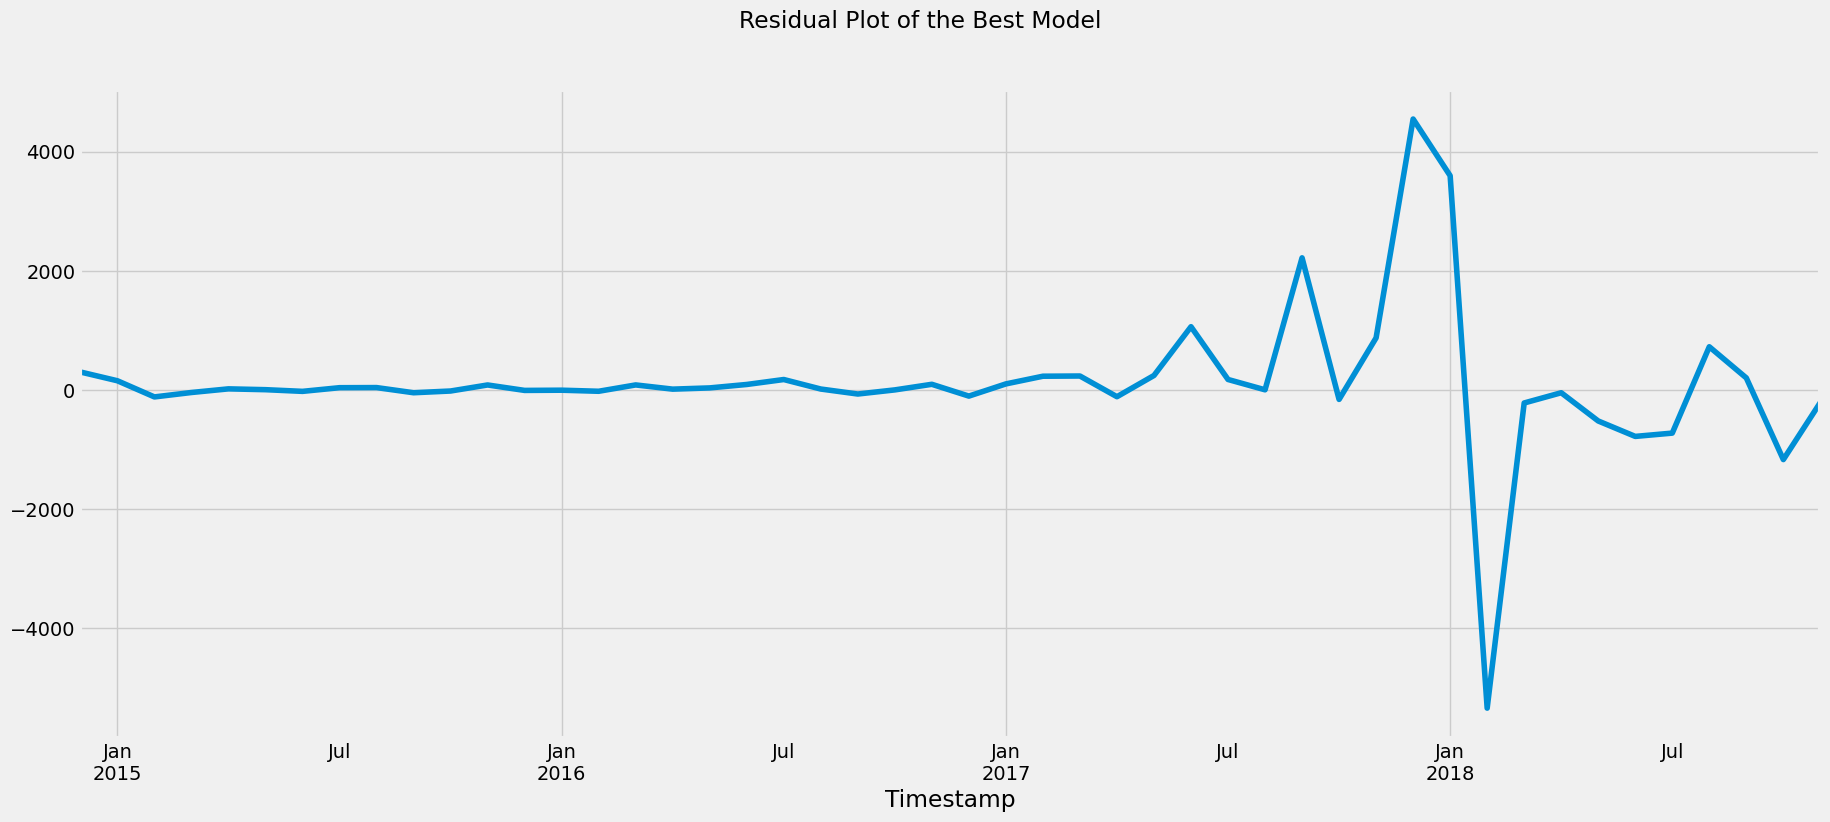

In [70]:
fig = plt.figure(figsize=(20,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

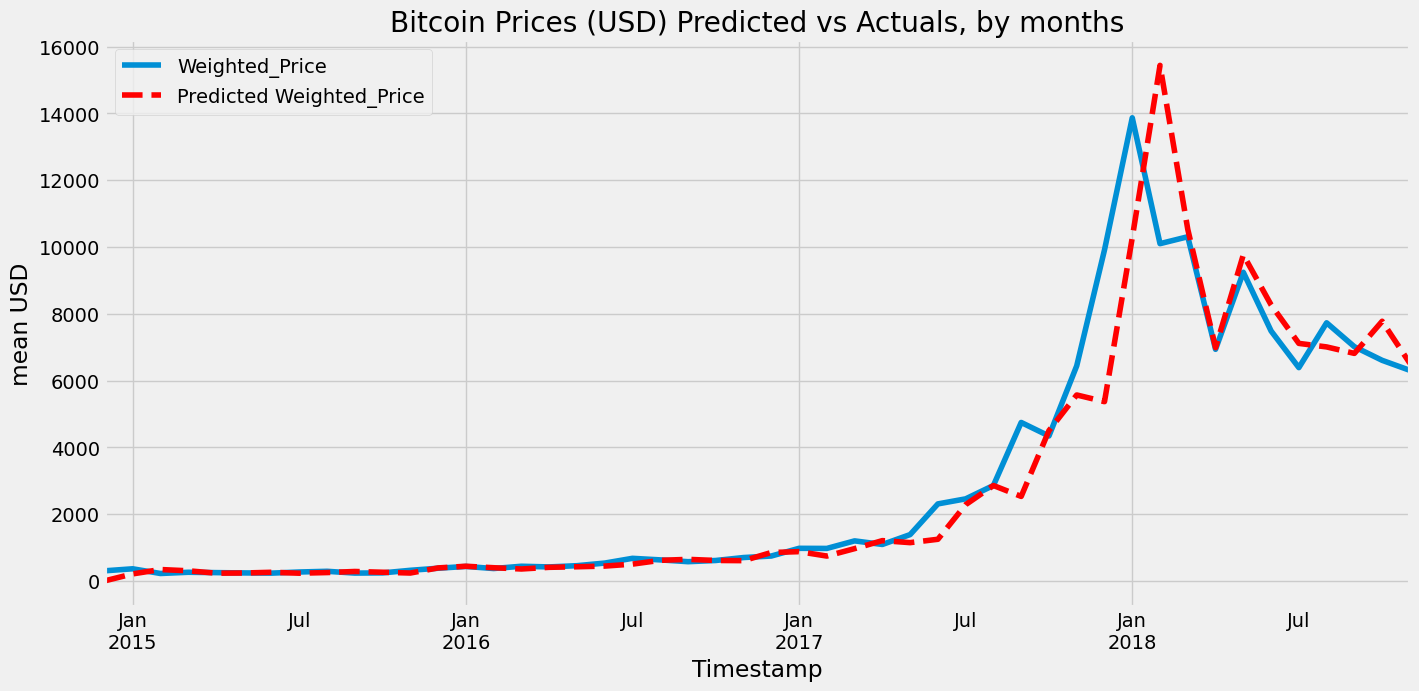

In [71]:
df_month2 = data[['Weighted_Price']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=200)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()

We can see how the above models perform with Historic Bitcoin Price data.  The prediction is not good. The Bitcoin prices are very volatile and very random, and is often influenced by external factors (or news) such as Cryptocurrency regulations, Investments or simple rumours on social media. We need additional data from news or social media to make these models perform better and more accurately.